# TransferLearning

In [2]:
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications import VGG16
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from tensorflow import keras
import numpy as np

In [3]:
# load the VGG16 network *pre-trained* on the ImageNet dataset
model = VGG16(weights="imagenet")
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

The model is expecting images in the shape of (224, 224, 3): 

224 pixels high

224 pixels wide

3 color channels

Keras models can accept more than one image at a time for prediction.

Goal: the image shape should be: (1, 224, 224, 3)

The model will return a prediction of shape 1000. 

Many of the categories are animals, including many types of dogs and cats. 

The dogs are categories 151 through 268. 

The cats are categories 281 through 285.

We will be able to use these categories to tell our doggy door what type of animal is at our door, and whether we should let them in or not.

In [4]:
def show_image(image_path):
    image = mpimg.imread(image_path)
    print(image.shape)
    plt.imshow(image)

(1200, 1800, 3)


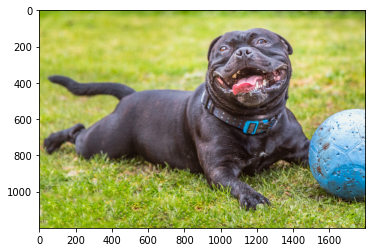

In [5]:
show_image("data/doggy_door_images/happy_dog.jpg")

# Preprocessing the Image

In [6]:
def load_and_process_image(image_path):
    # Print image's original shape, for reference
    print('Original image shape: ', mpimg.imread(image_path).shape)
    
    # Load in the image with a target size of 224, 224
    image = image_utils.load_img(image_path, target_size=(224, 224))
    # Convert the image from a PIL format to a numpy array
    image = image_utils.img_to_array(image)
    # Add a dimension for number of images, in our case 1
    image = image.reshape(1,224,224,3)
    # Preprocess image to align with original ImageNet dataset
    image = preprocess_input(image)
    # Print image's shape after processing
    print('Processed image shape: ', image.shape)
    return image

# Make a Prediction

In [7]:
def readable_prediction(image_path):
    # Show image
    show_image(image_path)
    # Load and pre-process image
    image = load_and_process_image(image_path)
    # Make predictions
    predictions = model.predict(image)
    # Print predictions in readable form
    print('Predicted:', decode_predictions(predictions, top=3))

(1200, 1800, 3)
Original image shape:  (1200, 1800, 3)
Processed image shape:  (1, 224, 224, 3)
Predicted: [[('n02093256', 'Staffordshire_bullterrier', 0.4509805), ('n02110958', 'pug', 0.32263243), ('n02099712', 'Labrador_retriever', 0.09343209)]]


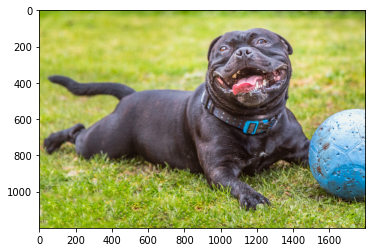

In [8]:
readable_prediction("data/doggy_door_images/happy_dog.jpg")

(2592, 3456, 3)
Original image shape:  (2592, 3456, 3)
Processed image shape:  (1, 224, 224, 3)
Predicted: [[('n02132136', 'brown_bear', 0.9853864), ('n02133161', 'American_black_bear', 0.013876191), ('n02410509', 'bison', 0.00026603678)]]


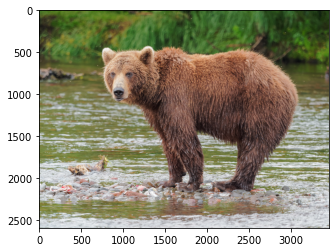

In [9]:
readable_prediction("data/doggy_door_images/brown_bear.jpg")

(1200, 1800, 3)
Original image shape:  (1200, 1800, 3)
Processed image shape:  (1, 224, 224, 3)
Predicted: [[('n02123159', 'tiger_cat', 0.73654705), ('n02124075', 'Egyptian_cat', 0.17492658), ('n02123045', 'tabby', 0.045884028)]]


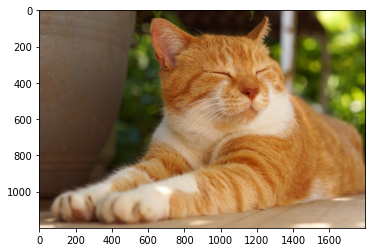

In [10]:
readable_prediction("data/doggy_door_images/sleepy_cat.jpg")

In [11]:
# Now that we are making predictions with our model, we can use our categories to only let dogs in and out and keep cats inside.
# Dogs are categories 151 through 268 and cats are categories 281 through 285.
# The np.argmax function can find which element of the prediction array is the top category.
def doggy_door(image_path):
    show_image(image_path)
    image = load_and_process_image(image_path)
    preds = model.predict(image)
    if 151 <= np.argmax(preds) <= 268:
        print("Doggy come on in!")
    elif 281 <= np.argmax(preds) <= 285:
        print("Kitty stay inside!")
    else:
        print("You're not a dog! Stay outside!")

(2592, 3456, 3)
Original image shape:  (2592, 3456, 3)
Processed image shape:  (1, 224, 224, 3)
You're not a dog! Stay outside!


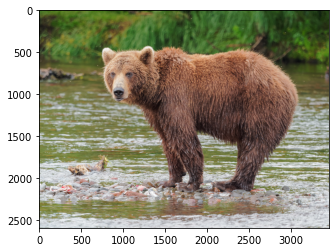

In [12]:
doggy_door("data/doggy_door_images/brown_bear.jpg")

(1200, 1800, 3)
Original image shape:  (1200, 1800, 3)
Processed image shape:  (1, 224, 224, 3)
Doggy come on in!


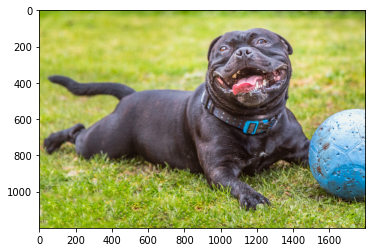

In [13]:
doggy_door("data/doggy_door_images/happy_dog.jpg")

(1200, 1800, 3)
Original image shape:  (1200, 1800, 3)
Processed image shape:  (1, 224, 224, 3)
Kitty stay inside!


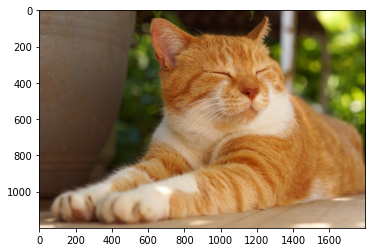

In [14]:
doggy_door("data/doggy_door_images/sleepy_cat.jpg")

# A Personalized Doggy Door

The challenge is that the pre-trained model was not trained to recognize this specific dog, and, we only have 30 pictures of Bo. 

If we tried to train a model from scratch using those 30 pictures we would experience overfitting and poor generalization.

However, if we start with a pre-trained model that is adept at detecting dogs, we can leverage that learning to gain a generalized understanding of Bo using our smaller dataset.

We can use transfer learning to solve this challenge.

In [15]:
base_model = keras.applications.VGG16(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False) # remove the last layer of the model.
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

# Freezing the Base Model
Freezing the model's pre-trained layers.

When we train, we will not update the base layers from the pre-trained model.

Instead we will only update the new layers that we add on the end for our new classification

We freeze the initial layers because we want to retain the learning achieved from training on the ImageNet dataset.

If they were unfrozen at this stage, we would likely destroy this valuable information. 

There will be an option to unfreeze and train these layers later, in a process called fine-tuning.

In [16]:
base_model.trainable = False

Add the new trainable layers to the pre-trained model.

They will take the features from the pre-trained layers and turn them into predictions on the new dataset. 

We will add two layers to the model.

1. A pooling layer like we saw in our earlier convolutional neural network. 
2. Final layer, which will classify Bo or not Bo. This will be a densely connected layer with one output.

In [17]:
inputs = keras.Input(shape=(224, 224, 3))
# Separately from setting trainable on the model, we set training to False 
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [18]:
model.summary() # Worth noting that we have many non-trainable parameters as we have frozen the pre-trained model.

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
Total params: 14,715,201
Trainable params: 513
Non-trainable params: 14,714,688
_________________________________________________________________


In [19]:
# from_logits=True: Inform the loss function that the output values are not normalized (e.g. with softmax).
# Important to use binary crossentropy and binary accuracy as we now have a binary classification problem
model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True), metrics=[keras.metrics.BinaryAccuracy()])

In [20]:
# create a data generator
datagen = ImageDataGenerator(
        samplewise_center=True,  # set each sample mean to 0
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False) # we don't expect Bo to be upside-down so we will not flip vertically

In [21]:
# load and iterate training dataset
train_it = datagen.flow_from_directory('data/presidential_doggy_door/train/', 
                                       target_size=(224, 224), 
                                       color_mode='rgb', 
                                       class_mode='binary', 
                                       batch_size=8)
# load and iterate validation dataset
valid_it = datagen.flow_from_directory('data/presidential_doggy_door/valid/', 
                                      target_size=(224, 224), 
                                      color_mode='rgb', 
                                      class_mode='binary', 
                                      batch_size=8)

Found 139 images belonging to 2 classes.
Found 30 images belonging to 2 classes.


In [22]:
model.fit(train_it, steps_per_epoch=12, validation_data=valid_it, validation_steps=4, epochs=20)

Epoch 1/20
12/12 [==============================] - 3s 246ms/step - loss: 0.8990 - binary_accuracy: 0.8021 - val_loss: 2.0941 - val_binary_accuracy: 0.6333
Epoch 2/20
12/12 [==============================] - 2s 204ms/step - loss: 0.6427 - binary_accuracy: 0.7912 - val_loss: 0.5465 - val_binary_accuracy: 0.7667
Epoch 3/20
12/12 [==============================] - 2s 148ms/step - loss: 0.3686 - binary_accuracy: 0.8681 - val_loss: 0.5590 - val_binary_accuracy: 0.7667
Epoch 4/20
12/12 [==============================] - 2s 144ms/step - loss: 0.2906 - binary_accuracy: 0.9062 - val_loss: 0.1570 - val_binary_accuracy: 0.9333
Epoch 5/20
12/12 [==============================] - 2s 143ms/step - loss: 0.1801 - binary_accuracy: 0.9341 - val_loss: 0.1922 - val_binary_accuracy: 0.9333
Epoch 6/20
12/12 [==============================] - 2s 160ms/step - loss: 0.1195 - binary_accuracy: 0.9670 - val_loss: 0.1136 - val_binary_accuracy: 0.9333
Epoch 7/20
12/12 [==============================] - 2s 148ms/ste

# Fix the fluctuation in the validation accuracy with fine-tuning
1. Unfreeze the entire model
2. Train it again with a very small learning rate. 

### This will cause the base pre-trained layers to take very small steps and adjust slightly, improving the model by a small amount.
* It is important to only do this step after the model with frozen layers has been fully trained. 
* The untrained pooling and classification layers that we added to the model earlier were randomly initialized.
* This means they needed to be updated quite a lot to correctly classify the images.
* Through the process of backpropagation, large initial updates in the last layers would have caused potentially large updates in the pre-trained layers as well. 
* These updates would have destroyed those important pre-trained features.
* However, now that those final layers are trained and have converged, any updates to the model as a whole will be much smaller (especially with a very small learning rate) and will not destroy the features of the earlier layers.

In [23]:
# Unfreeze the base model
base_model.trainable = True

# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are taken into account
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate = .00001),  # Very low learning rate
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

In [24]:
model.fit(train_it, steps_per_epoch=12, validation_data=valid_it, validation_steps=4, epochs=10)

Epoch 1/10
12/12 [==============================] - 7s 622ms/step - loss: 0.0044 - binary_accuracy: 1.0000 - val_loss: 0.0202 - val_binary_accuracy: 1.0000
Epoch 2/10
12/12 [==============================] - 2s 181ms/step - loss: 1.1167e-04 - binary_accuracy: 1.0000 - val_loss: 0.0387 - val_binary_accuracy: 0.9667
Epoch 3/10
12/12 [==============================] - 2s 175ms/step - loss: 3.4056e-05 - binary_accuracy: 1.0000 - val_loss: 0.0233 - val_binary_accuracy: 0.9667
Epoch 4/10
12/12 [==============================] - 2s 182ms/step - loss: 0.1174 - binary_accuracy: 0.9670 - val_loss: 0.0122 - val_binary_accuracy: 1.0000
Epoch 5/10
12/12 [==============================] - 2s 184ms/step - loss: 7.5571e-04 - binary_accuracy: 1.0000 - val_loss: 0.0071 - val_binary_accuracy: 1.0000
Epoch 6/10
12/12 [==============================] - 2s 173ms/step - loss: 8.3578e-06 - binary_accuracy: 1.0000 - val_loss: 0.0792 - val_binary_accuracy: 0.9667
Epoch 7/10
12/12 [==============================

In [25]:
def show_image(image_path):
    image = mpimg.imread(image_path)
    plt.imshow(image)

def make_predictions(image_path):
    show_image(image_path)
    image = image_utils.load_img(image_path, target_size=(224, 224))
    image = image_utils.img_to_array(image)
    image = image.reshape(1,224,224,3)
    image = preprocess_input(image)
    preds = model.predict(image)
    return preds

array([[-38.400528]], dtype=float32)

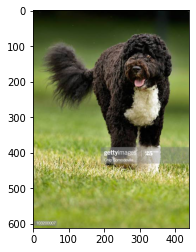

In [26]:
make_predictions('data/presidential_doggy_door/valid/bo/bo_20.jpg')

array([[20.432732]], dtype=float32)

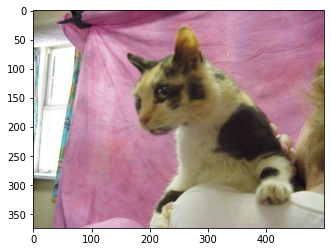

In [27]:
make_predictions('data/presidential_doggy_door/valid/not_bo/121.jpg')

In [28]:
# It looks like a negative number prediction means that it is Bo and a positive number prediction means it is something else. 
# We can use this information to have our doggy door only let Bo in!
def presidential_doggy_door(image_path):
    preds = make_predictions(image_path)
    if preds[0] < 0:
        print("It's Bo! Let him in!")
    else:
        print("That's not Bo! Stay out!")

That's not Bo! Stay out!


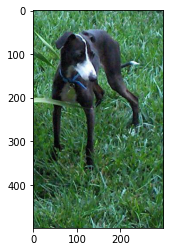

In [29]:
presidential_doggy_door('data/presidential_doggy_door/valid/not_bo/131.jpg')

It's Bo! Let him in!


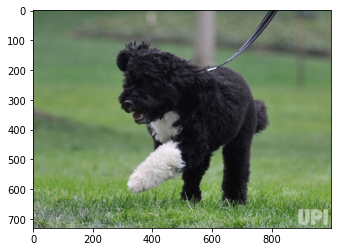

In [30]:
presidential_doggy_door('data/presidential_doggy_door/valid/bo/bo_29.jpg')